In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

from data import TRANSFORM, create_angle_features
from utils import TESTPATH, CLASS_MAPPINGS_NAMES, LANDMARKS_ANGLES_DICT, LANDMARK_DICT
from plot import plot_image, plot_3d_keypoints, plot_distribution, plot_distribution_with_image
from pose import pose_landmarks_to_list, estimate_poses
from classify import classify_image
from baseline import get_angle_confidence_intervals, create_pose_df, warrior_pose_front_back, front_leg, rename_columns

### Read in Image

In [4]:
PATH = "/0_warrior2/Ashton-warrior-2-wrong.jpg"
EXAMPLE_PATH = str(TESTPATH)+PATH

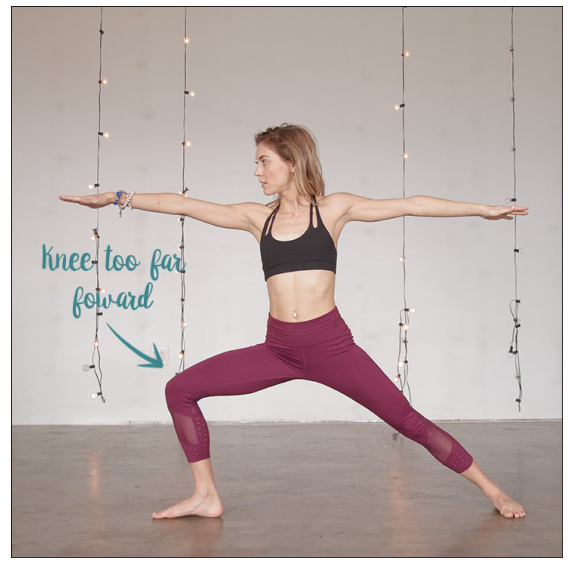

In [5]:
image = TRANSFORM(Image.open(EXAMPLE_PATH))
plot_image(image, dataloader=True)

### Apply Pose Estimation

In [6]:
result, annotated_image = estimate_poses(image, PATH, skip_image_annotation=False)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


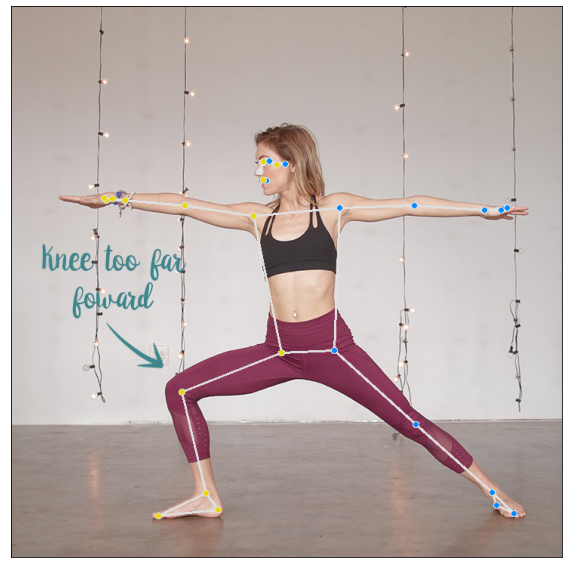

In [7]:
plot_image(annotated_image, dataloader=False)

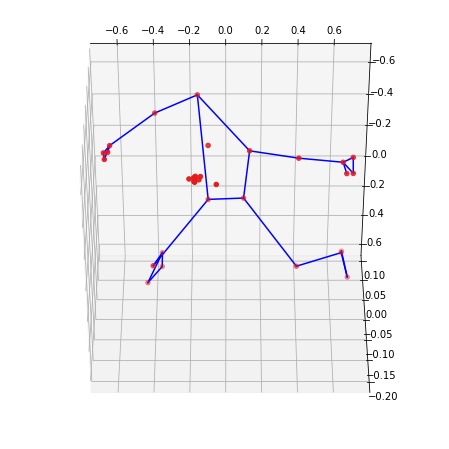

In [38]:
val, _, nump = pose_landmarks_to_list(result, 'pose_world_landmarks')

df = pd.DataFrame.from_records([val]).rename(LANDMARK_DICT, axis=1)
create_angle_features(df)

numpy_data = np.array([nump])

x = numpy_data[0].T[0]
y = numpy_data[0].T[1]
z = numpy_data[0].T[2]

plot_3d_keypoints(x, y, z, -50, 270)

### Pose Classification

In [39]:
label = classify_image(numpy_data).item()
print(f"Image Classified as : {CLASS_MAPPINGS_NAMES[label]}")

Image Classified as : W2


### Naive Pose Correction - Angles

In [40]:
if label in (1,2):
    df['forward'] = df.apply(
            lambda x: front_leg(x['LEFT_HIP'][0:3], x['RIGHT_HIP'][0:3], x['RIGHT_SHOULDER'][0:3],
                                x['LEFT_FOOT_INDEX'][0:3], x['RIGHT_FOOT_INDEX'][0:3]), axis=1)
    df = rename_columns(df, forward='RIGHT')
    df_angle = df.iloc[:,33:49]
else:
    # TODO for downward dog
    pass
#     df_angle = 

In [41]:
df_w1, df_w2, df_dd = create_pose_df()

df_w1, WARRIOR_LANDMARKS_ANGLES = warrior_pose_front_back(df_w1)
df_w2, _ = warrior_pose_front_back(df_w2)

dd_angles = get_angle_confidence_intervals(df_dd, LANDMARKS_ANGLES_DICT.keys(), percent = .15)
w1_angles = get_angle_confidence_intervals(df_w1, WARRIOR_LANDMARKS_ANGLES, percent = .15)
w2_angles = get_angle_confidence_intervals(df_w2, WARRIOR_LANDMARKS_ANGLES, percent = .15)

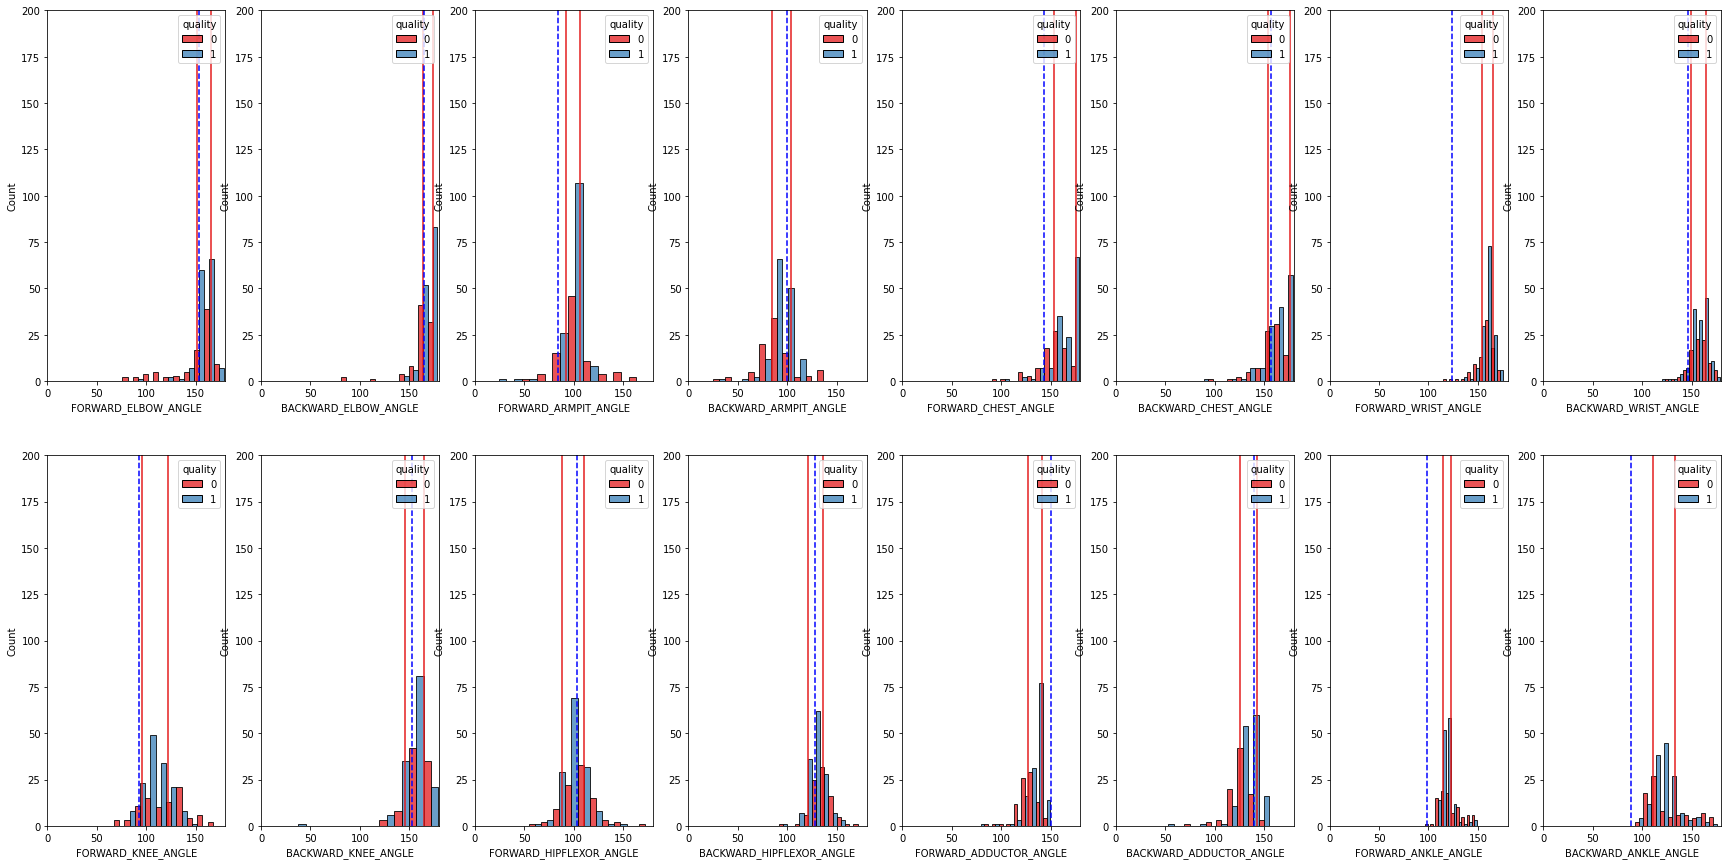

FORWARD_ARMPIT_ANGLE is to small by - 8.4
FORWARD_CHEST_ANGLE is to small by - 10.7
FORWARD_WRIST_ANGLE is to small by - 30.2
BACKWARD_WRIST_ANGLE is to small by - 3.5
FORWARD_KNEE_ANGLE is to small by - 3.1
FORWARD_ADDUCTOR_ANGLE is to large by - 9.3
FORWARD_ANKLE_ANGLE is to small by - 15.9
BACKWARD_ANKLE_ANGLE is to small by - 23.1


In [42]:
if label == 2:
    plot_distribution_with_image(df_w2, df_angle, w2_angles, WARRIOR_LANDMARKS_ANGLES)
elif label == 1:
    plot_distribution_with_image(df_dd, df_angle, dd_angles, LANDMARKS_ANGLES_DICT.keys())
elif label == 0:
    plot_distribution_with_image(df_w1, df_angle, w1_angles, WARRIOR_LANDMARKS_ANGLES)    

### Naive Pose Correction - 3D Limbs & Angles

In [ ]:
# TODO : Have to refactor this section still to make it work for a new image
# Need to have some sort of decision process for which image it will compare itself against


In [12]:
def calc_2d_angles(vec_2d):
    return np.degrees(np.arctan2(vec_2d[1], vec_2d[0]))

def calc_xyz_angles(vec):
    xy_points = vec[0:2]
    yz_points = vec[1:3]
    
    xy_angle = calc_2d_angles(xy_points)
    yz_angle = calc_2d_angles(yz_points)
    
    return xy_angle, yz_angle

def calc_xyz_dist(vec):
    xy_points = vec[0:2]
    yz_points = vec[1:3]
    
    xy_dist = np.linalg.norm(xy_points, axis=0)
    yz_dist = np.linalg.norm(yz_points, axis=0)
    
    return xy_dist, yz_dist

def calc_xyz_points(xy_angle, xy_dist, yz_angle, yz_dist):
    x, y1 = calc_2d_points(xy_angle, xy_dist)
    y2, z = calc_2d_points(yz_angle, yz_dist)
    
    return x, y1, z
    
def calc_2d_points(angle, dist):
    a = dist * np.cos(np.radians(angle))
    b = dist * np.sin(np.radians(angle))
    return a, b

In [13]:
def compare_two_figures(length_fig_idx, angle_fig_idx, df, annotated_images, plot=True):
    RIGHT_HIP = 24
    
    #normalize based on right hip
    length_fig = df[length_fig_idx] - np.tile(df[length_fig_idx][RIGHT_HIP], (df[length_fig_idx].shape[0],1))
    angle_fig = df[angle_fig_idx] - np.tile(df[angle_fig_idx][RIGHT_HIP], (df[angle_fig_idx].shape[0],1))
    
    plot_image_grid([annotated_images[length_fig_idx], annotated_images[angle_fig_idx]], 2)
    
    xy_dist, yz_dist = calc_xyz_dist(length_fig.T)
    xy_angle, yz_angle = calc_xyz_angles(angle_fig.T)
    
    px, py, pz = calc_xyz_points(xy_angle, xy_dist, yz_angle, yz_dist)
    lx, ly, lz = length_fig.T[0], length_fig.T[1], length_fig.T[2]
    angx, angy, angz = angle_fig.T[0], angle_fig.T[1], angle_fig.T[2]
    
    if plot:
        fig = plt.figure()
        ax = plt.axes(projection="3d")
        ax.scatter3D(px, py, pz)
        ax.scatter3D(lx, ly, lz)
        ax.scatter3D(angx, angy, angz)
        #ax.plot(points[0],points[1],points[2],color = 'g')
        for i,j in BODY_POSE_CONNECTIONS:
            ax.plot([px[i],px[j]], [py[i],py[j]], [pz[i],pz[j]], color='r')
            ax.plot([lx[i],lx[j]], [ly[i],ly[j]], [lz[i],lz[j]], color='g')
            ax.plot([angx[i],angx[j]], [angy[i],angy[j]], [angz[i],angz[j]], color='b')
        plt.show()

### GAN Pose Correction

In [ ]:
# Put stick figure into GAN
# Get out corrected image